In [6]:
from dataset import get_mnist_dataset

x_test, y_test = get_mnist_dataset()

/scratch/sagar/Projects/learn/compressai/venv/lib/python3.6/site-packages/torch/nn/functional.py:3888: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/scratch/sagar/Projects/learn/compressai/venv/lib/python3.6/site-packages/torch/nn/functional.py:3826: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


In [1]:
import torch
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, Dataset
import torchvision
import torch.nn.functional as F
import numpy as np

def get_flip_indices(y_sorted):
    flip_indices = []
    current_int = y_sorted[0]
    for i in range(len(y_sorted)):
        if current_int !=y_sorted[i]:
            current_int = y_sorted[i]
            flip_indices.append(i)         
    return flip_indices

def get_mnist_dataset(train=True, normalize=True, total_data=None):
    if total_data is None:
        batch_size = 60000 if train else 10000
    else:
        batch_size = total_data
        
    if normalize:
        mean = (0.1307, )
        std = (0.3081, )
    else:
        mean = (0, )
        std = (1, )

    transform_rotate = torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   Rotate(np.pi/4),
                                   torchvision.transforms.Normalize(
                                     mean, std)
                                 ])
    
    transform_original = torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                     mean, std)
                                 ])
    
    transform_noise = torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       mean, std),
                                   AddNoise(0.4)
                                 ])

    dataset_rotated = datasets.MNIST(root='./data', train=train, download=True, transform=transform_rotate)
    dataset_original = datasets.MNIST(root='./data', train=train, download=True, transform=transform_original)
    dataset_noisy = datasets.MNIST(root='./data', train=train, download=True, transform=transform_noise)

    dataloader_rotated = torch.utils.data.DataLoader(dataset_rotated, batch_size=batch_size,
                                          shuffle=False, num_workers=5)
    dataloader_noisy = torch.utils.data.DataLoader(dataset_noisy, batch_size=batch_size,
                                          shuffle=False, num_workers=5)
    dataloader_original = torch.utils.data.DataLoader(dataset_original, batch_size=batch_size,
                                          shuffle=False, num_workers=5)

    x_test, y_test = torch.stack((next(iter(dataloader_original))[0],
                     next(iter(dataloader_rotated))[0],
                     next(iter(dataloader_noisy))[0]
                    )), next(iter(dataloader_original))[1]
    
    a = np.argsort(y_test)
    x_test = x_test[:, a, :, :, :]
    y_test = y_test[a]

    flip_idx = get_flip_indices(y_test)
    flip_idx = flip_idx + [len(y_test)]

    for view in range(len(x_test)):
        randperms = torch.cat([flip_idx[i]+torch.randperm(flip_idx[i+1]-flip_idx[i]) for i in range(len(flip_idx)-1)])
        x_test[view] = x_test[view,randperms,:,:,:]
        
    return x_test, y_test

In [5]:
import torch
x_test = torch.zeros((3,60000,1,28,28))
y_test = torch.cat([i*torch.ones(6000) for i in range(10)])
a = np.argsort(y_test)
x_test = x_test[:, a, :, :, :]
y_test = y_test[a]

flip_idx = get_flip_indices(y_test)
flip_idx = flip_idx + [len(y_test)]

for view in range(len(x_test)):
    randperms = torch.cat([flip_idx[i]+torch.randperm(flip_idx[i+1]-flip_idx[i]) for i in range(len(flip_idx)-1)])
    x_test[view] = x_test[view,randperms,:,:,:]


RuntimeError: The expanded size of the tensor (60000) must match the existing size (54000) at non-singleton dimension 0.  Target sizes: [60000, 1, 28, 28].  Tensor sizes: [54000, 1, 28, 28]

## DGCCA MNIST without AE architecture

In [18]:
from collections import OrderedDict, namedtuple
from itertools import product
import os
from tqdm import tqdm, trange
from IPython.display import clear_output
import time
import torch.nn as nn
import pandas as pd
import torch
import matplotlib.pyplot as plt
from utils.run_manager import RunBuilder
from models import g_step, MnistDGCCA
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import torchvision
from dataset import get_mnist_dataset 
import numpy as np

class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

if torch.cuda.is_available():
    devices = ['cpu']
else:
    devices = ['cpu']
print('starting')


params = OrderedDict(
    lr = [0.001],
    batch_size = [1000],
    device = devices,
    shuffle = [True],
    num_workers = [5],
    manual_seed = [1265],
    loss_func = [nn.MSELoss],
    quant = [False]
)

# layer_sizes_list = 3*[[128, 64, 2]]
# input_size_list = 3*[2]


run_count = 0
models = []


run_data = []

data_load_time = 0
forward_time = 0


for run in RunBuilder.get_runs(params):
#     torch.cuda.set_device(run.device)
    
    run_count += 1
    device = torch.device(run.device)
    
    dgcca = MnistDGCCA(output_size=2)
    dgcca = dgcca.to(device)


    train_set, train_classes = get_mnist_dataset(train=True)
    val_set, val_classes = get_mnist_dataset(train=False)
    
    train_views = list(train_set.to(device))
    val_views = list(train_set.to(device))
    
#     one_hot_train = torch.zeros((len(train_classes), 10))
#     one_hot_train[torch.arange(len(train_classes)), train_classes] = 1
#     train_views.append(one_hot_train.to(device))
    
#     one_hot_val = torch.zeros((len(val_classes), 10))
#     one_hot_val[torch.arange(len(val_classes)), val_classes] = 1
#     val_views.append(one_hot_val.to(device))
    
    optimizer = torch.optim.Adam(dgcca.parameters(), lr=run.lr)
    num_batches = len(train_views[0])//run.batch_size
    
    criterion = run.loss_func()

    out = torch.stack(dgcca(train_views))
    G = g_step(out.clone().detach())  
    
    M_serv = out.clone()
    M_diff = out.clone()
    
    I = len(train_views)
    
    for epoch in range(100):
        total_recons_loss = 0
        total_val_loss = 0
        batch_count = 0
        
        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/num_batches
        results['val_fidelity'] = total_recons_loss/num_batches
        
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device

        df2 = pd.DataFrame.from_dict(run_data, orient='columns')
        
        for i in range(num_batches):
            optimizer.zero_grad()
            batch = []
            
            # mini batch gradient
            batch = [view[(i*run.batch_size):((i+1)*run.batch_size), :] for view in train_views]            
            target = G[(i*run.batch_size):((i+1)*run.batch_size), :]
            
            # full gradient
#             batch = train_views
#             target = G
#             print(batch[0].shape)
#             out = dgcca(batch)
#             out = torch.stack(out)  

            loss = 1/2*torch.norm(torch.stack(dgcca(batch))-target)/target.shape[0]
            
            loss.backward()
            optimizer.step()
            
            total_recons_loss += loss.item()
            
        ## initialize G
#         out = dgcca(train_views)
        dgcca.eval()
        out = torch.stack(dgcca(train_views))
        
        if run.quant:
            for i in range(I):
                M_diff[i] = out[i] - M_serv[i]
                max_val = M_diff[i].abs().max()
                M_quant = ((1/max_val)*M_diff[i]).round()*(max_val/1)
                M_serv[i] += M_quant
            G = g_step(M_serv.clone().detach())    
        else:
            G = g_step(out.clone().detach())    
            
        # validation loss
        out_val = dgcca(val_views)
        out_val = torch.stack(out_val)
        
        G_val = g_step(out_val.clone().detach())
        
        loss_val = criterion(out_val, G_val)
        total_val_loss += loss_val.item()

        dgcca.train()
        
        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/num_batches/10
        results['val_fidelity'] = total_val_loss
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device
        
        run_data.append(results)
        df2 = pd.DataFrame.from_dict(run_data, orient='columns')
        clear_output(wait=True)
#         show_latent()
        display(df2)
            
#             m.track_loss(G_adv_loss=losses['beta_kl-divergence'], G_mse_loss=losses[''], D_real_loss=total_D_real, D_fake_loss=total_D_fake, D_real_count=real_count, D_fake_count=fake_count)
#         print(epoch, "total_Gloss:",total_Gloss, "total_Dloss:",total_Dloss, "mse:",total_mse_loss, "adv: ", total_adv_loss)           
#         m.end_epoch()
        torch.save(dgcca, 'trained_models/dgcca_mnist.model')

,run_count,epoch,data_fidelity,val_fidelity,batch_size,lr,device
0,1,0,0.000630,0.003412,1000,0.001,cpu
1,1,1,0.000149,0.001229,1000,0.001,cpu
2,1,2,0.000123,0.000483,1000,0.001,cpu
3,1,3,0.000105,0.000790,1000,0.001,cpu
4,1,4,0.000105,0.000848,1000,0.001,cpu
...,...,...,...,...,...,...,...
56,1,56,0.000080,0.000634,1000,0.001,cpu
57,1,57,0.000072,0.000315,1000,0.001,cpu
58,1,58,0.000064,0.000287,1000,0.001,cpu
59,1,59,0.000054,0.000376,1000,0.001,cpu


KeyboardInterrupt: 

In [2]:
from dataset import get_mnist_dataset
train_set, train_classes = get_mnist_dataset(train=True, shuffle=True, normalize=False)
val_set, val_classes = get_mnist_dataset(train=False, total_data=1000, shuffle=True, normalize=False)

train_set = train_set.view(train_set.shape[0], train_set.shape[1], -1)
val_set = val_set.view(val_set.shape[0], val_set.shape[1], -1)

from collections import OrderedDict, namedtuple
from itertools import product
import os
from tqdm import tqdm, trange
from IPython.display import clear_output
import time
import torch.nn as nn
import pandas as pd
import torch
import matplotlib.pyplot as plt
from utils.run_manager import RunBuilder
from models import g_step, MnistAEDGCCA, MnistAELinear, MnistAELinearBN
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import torchvision
from dataset import get_mnist_dataset 
import numpy as np

from torch.optim.lr_scheduler import MultiStepLR

class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

if torch.cuda.is_available():
    devices = ['cpu']
else:
    devices = ['cpu']
print('starting')


params = OrderedDict(
    lr = [0.001],
    batch_size = [1000],
    device = devices,
    shuffle = [True],
    num_workers = [5],
    manual_seed = [1265],
    loss_func = [nn.MSELoss],
    quant = [True],
    latent_dim = [10], 
    num_inner_epochs = [1]
)

# layer_sizes_list = 3*[[128, 64, 2]]
# input_size_list = 3*[2]


run_count = 0
models = []


run_data = []

data_load_time = 0
forward_time = 0
n_levels = 1
diff_norm = 0

for run in RunBuilder.get_runs(params):
#     torch.cuda.set_device(run.device)
    
    run_count += 1
    device = torch.device(run.device)
    
    dgcca = MnistAEDGCCA(output_size=run.latent_dim, network=MnistAELinearBN)
    dgcca = dgcca.to('cpu')
        
    train_views = list(train_set.to('cpu'))
    val_views = list(val_set.to('cpu'))
    
    optimizer = torch.optim.Adam(dgcca.parameters(), lr=run.lr)
    scheduler = MultiStepLR(optimizer, [30,70], gamma=0.8)
    num_batches = len(train_views[0])//run.batch_size
    
    criterion = run.loss_func()

    out = torch.stack(dgcca(train_views))
    G = g_step(out.clone().detach())  
    
    M_serv = out.detach().clone()
    
    I = len(train_views)
    
    for epoch in range(200):
        total_recons_loss = 0
        total_val_loss = 0
        batch_count = 0
        total_ae_loss = 0
        total_dgcca_loss = 0
        
        dgcca.train()
        dgcca.to('cuda')
        
        for _ in trange(run.num_inner_epochs):
            for i in trange(num_batches):

                optimizer.zero_grad()
                batch = []

                # mini batch gradient
                batch = [view[(i*run.batch_size):((i+1)*run.batch_size), :].to('cuda') for view in train_views]            
                target = G[(i*run.batch_size):((i+1)*run.batch_size), :].to('cuda')

                latent = dgcca(batch)

                ae_loss = (run.latent_dim/(2*28*28*target.shape[0]))*torch.norm(torch.stack(dgcca.decode(latent)) - torch.stack(batch))
                
                dgcca_loss = 1/2*torch.norm(torch.stack(latent)-target)/target.shape[0] 

                loss = dgcca_loss + 0.1*ae_loss

                loss.backward()

                optimizer.step()

                total_recons_loss += loss.item()
                total_ae_loss += ae_loss.item()
                total_dgcca_loss += dgcca_loss.item()
                del batch, target, latent
        
        scheduler.step()
        
        dgcca.eval()
        dgcca.to('cpu')
        out = torch.stack(dgcca(train_views)).detach().clone()        
        if run.quant:
            for i in range(I):
                diff = out[i] - M_serv[i]
                max_val = diff.abs().max()
                quant = ((1/max_val)*diff[i]).round()*(max_val/1)
                var = M_serv[i] + quant
                M_serv[i] = var
                diff_norm = torch.norm(diff, 'fro')
                del max_val, diff, quant, var
            G = g_step(M_serv.clone().detach())
        else:
            G = g_step(out.clone().detach())   
            
        # validation loss
        out_val = dgcca(val_views)
        out_val = torch.stack(out_val)
        
        G_val = g_step(out_val.clone().detach())
        
        
        loss_val = 1/2*torch.norm(out_val-G_val)/G_val.shape[0]
        total_val_loss += loss_val.item()
        del out, G_val, out_val

        
        results = OrderedDict()
        results['epoch'] = epoch
        results['total_loss'] = total_recons_loss/(num_batches*run.num_inner_epochs)
        results['ae_loss'] = total_ae_loss/(num_batches*run.num_inner_epochs)
        results['dgcca_loss'] = total_dgcca_loss/(num_batches*run.num_inner_epochs)
        results['val_fidelity'] = total_val_loss
        results['diff_norm'] = diff_norm
        results['lr'] = run.lr
        
#         if results['data_fidelity'] < 0.00275:
#             break
        
        run_data.append(results)
        df3 = pd.DataFrame.from_dict(run_data, orient='columns')
        clear_output(wait=True)
#         show_latent()
        display(df3)
        df3.to_pickle('plt/fed_linearBN11_fed.pkl')
#             m.track_loss(G_adv_loss=losses['beta_kl-divergence'], G_mse_loss=losses[''], D_real_loss=total_D_real, D_fake_loss=total_D_fake, D_real_count=real_count, D_fake_count=fake_count)
#         print(epoch, "total_Gloss:",total_Gloss, "total_Dloss:",total_Dloss, "mse:",total_mse_loss, "adv: ", total_adv_loss)           
#         m.end_epoch()
        torch.save(dgcca, 'trained_models/dgcca_mnist_linearBN11_fed_innerit1.model')
        

,epoch,total_loss,ae_loss,dgcca_loss,val_fidelity,diff_norm,lr
0,0,0.007287,0.003436,0.006944,0.002624,tensor(184.3750),0.001
1,1,0.002039,0.003303,0.001709,0.002585,tensor(240.2648),0.001
2,2,0.001846,0.003262,0.001520,0.002791,tensor(234.5724),0.001
3,3,0.002438,0.003184,0.002120,0.002831,tensor(236.7381),0.001
4,4,0.002184,0.003073,0.001877,0.002907,tensor(234.6151),0.001
...,...,...,...,...,...,...,...
195,195,0.001102,0.002751,0.000827,0.002573,tensor(234.9157),0.001
196,196,0.001097,0.002773,0.000820,0.002538,tensor(237.6213),0.001
197,197,0.001098,0.002775,0.000820,0.002585,tensor(233.7188),0.001
198,198,0.001093,0.002770,0.000816,0.002543,tensor(236.9537),0.001


In [8]:
df3.to_pickle('plt/fed_linear.pkl')

In [5]:
optimizer.lr

AttributeError: 'Adam' object has no attribute 'lr'

In [5]:
i=1
dgcca.to('cuda')
batch = [view[(i*run.batch_size):((i+1)*run.batch_size), :].to('cuda') for view in train_views]            
target = G[(i*run.batch_size):((i+1)*run.batch_size), :].to('cuda')

latent = dgcca(batch)
dgcca.decode(latent)

[tensor([[0.4684, 0.5717, 0.4222,  ..., 0.5699, 0.4646, 0.6085],
         [0.4684, 0.5717, 0.4222,  ..., 0.5699, 0.4646, 0.6085],
         [0.4684, 0.5717, 0.4222,  ..., 0.5699, 0.4646, 0.6085],
         ...,
         [0.4684, 0.5717, 0.4222,  ..., 0.5699, 0.4646, 0.6085],
         [0.4684, 0.5717, 0.4222,  ..., 0.5699, 0.4646, 0.6085],
         [0.4684, 0.5717, 0.4222,  ..., 0.5699, 0.4646, 0.6085]],
        device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.4412, 0.4633, 0.4217,  ..., 0.5753, 0.5651, 0.4772],
         [0.4412, 0.4633, 0.4217,  ..., 0.5753, 0.5651, 0.4772],
         [0.4412, 0.4633, 0.4217,  ..., 0.5753, 0.5651, 0.4772],
         ...,
         [0.4412, 0.4633, 0.4217,  ..., 0.5753, 0.5651, 0.4772],
         [0.4412, 0.4633, 0.4217,  ..., 0.5753, 0.5651, 0.4772],
         [0.4412, 0.4633, 0.4217,  ..., 0.5753, 0.5651, 0.4772]],
        device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[0.4416, 0.3838, 0.4780,  ..., 0.4317, 0.4430, 0.4339],
         [0.4416, 0

In [6]:
latent

[tensor([[-0.0002,  0.0006, -0.0001,  ...,  0.0040, -0.0004, -0.0037],
         [ 0.0004,  0.0016,  0.0010,  ...,  0.0042, -0.0005, -0.0040],
         [ 0.0026, -0.0042,  0.0030,  ...,  0.0025, -0.0059,  0.0019],
         ...,
         [ 0.0004,  0.0038, -0.0036,  ...,  0.0010, -0.0053, -0.0014],
         [ 0.0048,  0.0006,  0.0010,  ..., -0.0020, -0.0008,  0.0020],
         [ 0.0012, -0.0025, -0.0008,  ..., -0.0050, -0.0010, -0.0040]],
        device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[ 0.0010,  0.0034,  0.0023,  ...,  0.0032,  0.0002, -0.0055],
         [ 0.0033,  0.0020,  0.0032,  ...,  0.0017, -0.0013, -0.0035],
         [ 0.0027, -0.0062,  0.0045,  ...,  0.0040, -0.0076,  0.0016],
         ...,
         [ 0.0038, -0.0012, -0.0070,  ...,  0.0021, -0.0015,  0.0029],
         [ 0.0055,  0.0006,  0.0045,  ..., -0.0004,  0.0011, -0.0009],
         [ 0.0027, -0.0018,  0.0011,  ..., -0.0076, -0.0004, -0.0071]],
        device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[-4.458

In [3]:
df2.to_pickle("plt/dgcca_mnist_ae1.pkl")

In [2]:
from dataset import get_mnist_dataset
train_set, train_classes = get_mnist_dataset(train=True, shuffle=True)
val_set, val_classes = get_mnist_dataset(train=False, total_data=1000, shuffle=True)


/scratch/sagar/Projects/learn/compressai/venv/lib/python3.6/site-packages/torch/nn/functional.py:3888: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/scratch/sagar/Projects/learn/compressai/venv/lib/python3.6/site-packages/torch/nn/functional.py:3826: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/scratch/sagar/Projects/learn/compressai/venv/lib/python3.6/site-packages/torch/nn/functional.py:3826: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify al

## DGCCA Autoencoder MNIST

In [7]:

from collections import OrderedDict, namedtuple
from itertools import product
import os
from tqdm import tqdm_notebook as tqdm
from tqdm import trange
from IPython.display import clear_output
import time
import torch.nn as nn
import pandas as pd
import torch
import matplotlib.pyplot as plt
from utils.run_manager import RunBuilder
from models import g_step, MnistAEDGCCA
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import torchvision
from dataset import get_mnist_dataset 
import numpy as np

class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

if torch.cuda.is_available():
    devices = ['cpu']
else:
    devices = ['cpu']
print('starting')


params = OrderedDict(
    lr = [0.001],
    batch_size = [1000],
    device = devices,
    shuffle = [True],
    num_workers = [5],
    manual_seed = [1265],
    loss_func = [nn.MSELoss],
    quant = [False],
    latent_dim = [10], 
    num_inner_epochs = [3]
)

# layer_sizes_list = 3*[[128, 64, 2]]
# input_size_list = 3*[2]


run_count = 0
models = []


run_data = []

data_load_time = 0
forward_time = 0


for run in RunBuilder.get_runs(params):
#     torch.cuda.set_device(run.device)
    
    run_count += 1
    device = torch.device(run.device)
    
    dgcca = MnistAEDGCCA(output_size=run.latent_dim)
    dgcca = dgcca.to('cpu')
        
    train_views = list(train_set.to('cpu'))
    val_views = list(val_set.to('cpu'))
    
    optimizer = torch.optim.Adam(dgcca.parameters(), lr=run.lr)
    num_batches = len(train_views[0])//run.batch_size
    
    criterion = run.loss_func()

    out = torch.stack(dgcca(train_views))
    G = g_step(out.clone().detach())  
    
    M_serv = out.detach().clone()
    
    I = len(train_views)
    
    for epoch in range(60):
        total_recons_loss = 0
        total_val_loss = 0
        batch_count = 0
        total_dgcca_loss = 0
        
        dgcca.to('cuda')
        
        for _ in tqdm(range(run.num_inner_epochs)):
            for i in tqdm(range(num_batches)):

                optimizer.zero_grad()
                batch = []

                # mini batch gradient
                batch = [view[(i*run.batch_size):((i+1)*run.batch_size), :].to('cuda') for view in train_views]            
                target = G[(i*run.batch_size):((i+1)*run.batch_size), :].to('cuda')

                latent = dgcca(batch)

                ae_loss = (run.latent_dim/(2*28*28*target.shape[0]))*torch.norm(torch.stack(dgcca.decode(latent)) - torch.stack(batch))

                dgcca_loss = 1/2*torch.norm(torch.stack(latent)-target)/target.shape[0] 

                loss = dgcca_loss + ae_loss

                loss.backward()

                optimizer.step()

                total_recons_loss += loss.item()
                total_dgcca_loss += dgcca_loss.item()
#                 print(ae_loss.item(), dgcca_loss.item())
                del batch, target, latent

        dgcca.to('cpu')
        out = torch.stack(dgcca(train_views)).detach().clone()        
        if run.quant:
            for i in range(I):
                diff = out[i] - M_serv[i]
                max_val = diff.abs().max()
                quant = ((1/max_val)*diff[i]).round()*(max_val/1)
                var = M_serv[i] + quant
                M_serv[i] = var
                del max_val, diff, quant, var
            G = g_step(M_serv.clone().detach())
        else:
            G = g_step(out.clone().detach())   
            
        # validation loss
        out_val = dgcca(val_views)
        out_val = torch.stack(out_val)
        
        G_val = g_step(out_val.clone().detach())
        
        loss_val = criterion(out_val, G_val)
        total_val_loss += loss_val.item()
        del out, G_val, out_val

        
        results = OrderedDict()
        results['epoch'] = epoch
        results['train_loss'] = total_recons_loss/(num_batches*run.num_inner_epochs)
        results['dgcca_loss'] = total_dgcca_loss/(num_batches*run.num_inner_epochs)
        results['val_loss'] = total_val_loss
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        
        run_data.append(results)
        df3 = pd.DataFrame.from_dict(run_data, orient='columns')
        clear_output(wait=True)
#         show_latent()
        display(df3)
            
#             m.track_loss(G_adv_loss=losses['beta_kl-divergence'], G_mse_loss=losses[''], D_real_loss=total_D_real, D_fake_loss=total_D_fake, D_real_count=real_count, D_fake_count=fake_count)
#         print(epoch, "total_Gloss:",total_Gloss, "total_Dloss:",total_Dloss, "mse:",total_mse_loss, "adv: ", total_adv_loss)           
#         m.end_epoch()
        torch.save(dgcca, 'trained_models/dgcca_mnist_ae2_shuffled.model')

,epoch,train_loss,dgcca_loss,val_loss,batch_size,lr
0,0,0.011063,0.002754,0.001133,1000,0.001
1,1,0.008607,0.001495,0.000695,1000,0.001
2,2,0.007407,0.001358,0.000653,1000,0.001
3,3,0.007034,0.001365,0.001089,1000,0.001
4,4,0.007107,0.001535,0.000749,1000,0.001
5,5,0.006551,0.001226,0.000778,1000,0.001
6,6,0.006598,0.001292,0.000698,1000,0.001
7,7,0.006570,0.001347,0.000708,1000,0.001
8,8,0.006246,0.001146,0.000728,1000,0.001
9,9,0.006211,0.001160,0.000800,1000,0.001


In [5]:
dgcca_loss

tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>)

In [2]:
print('a')

a


## Classifier MNIST

In [ ]:
vanilla = torch.load('trained_models/dgcca_sgd_classifier.model')
fed = torch.load('trained_models/dgcca_fed_sgd_classifier.model')

val_set, val_classes = get_mnist_dataset(train=False)
val_views = list(train_set.to(device))
    
# out1 = dgcca_vanilla(train_views)

out1 = dgcca_vanilla(val_views)
G1 = g_step(torch.stack(out1).clone().detach())
out1 = [a.type(torch.float32).detach() for a in out1]

out2 = dgcca_fed(val_views)
G2 = g_step(torch.stack(out2).clone().detach())
out2 = [a.type(torch.float32).detach() for a in out2]

vanilla_class = []
for i in range(3):
    a = vanilla.model_list[i](out1[i])
    vanilla_class.append((a.squeeze().round() - train_classes[i].to('cuda')).abs().sum())
    
a = vanilla.model_list[3](G1.type(torch.float32))
vanilla_class.append((a.squeeze().round() - train_classes[0].to('cuda')).abs().sum())


fed_class = []
for i in range(3):
    a = fed.model_list[i](out2[i])
    fed_class.append((a.squeeze().round() - train_classes[i].to('cuda')).abs().sum())
    
a = fed.model_list[3](G2.type(torch.float32))
fed_class.append((a.squeeze().round() - train_classes[0].to('cuda')).abs().sum())

In [4]:
from collections import OrderedDict, namedtuple
from itertools import product
import os
from tqdm import tqdm, trange
from IPython.display import clear_output
import time
import torch.nn as nn
import pandas as pd
import torch
import matplotlib.pyplot as plt
from utils.run_manager import RunBuilder
from models import g_step, DeepGCCA, DGCCAClassifierMnist
from dataset import get_mnist_dataset
import numpy as np

class RunBuilder():
    @staticmethod
    def get_runs(params):

        Run = namedtuple('Run', params.keys())

        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))

        return runs

if torch.cuda.is_available():
    devices = ['cpu']
else:
    devices = ['cpu']
print('starting')


params = OrderedDict(
    lr = [0.001],
    batch_size = [1000],
    device = devices,
    shuffle = [True],
    num_workers = [5],
    manual_seed = [1265],
    loss_func = [nn.CrossEntropyLoss],
    num_views = [4], 
    latent_dim = [10]
)

layer_sizes_list = 3*[[128, 64, 2]]
input_size_list = 3*[2]


run_count = 0
models = []


run_data = []

data_load_time = 0
forward_time = 0


for run in RunBuilder.get_runs(params):

    run_count += 1
    device = torch.device(run.device)
    
    classifier = DGCCAClassifierMnist(num_views=run.num_views)
    classifier.to(device)
    dgcca = torch.load('trained_models/dgcca_mnist_ae1_shuffled_linear.model')
    dgcca.to(device)
    dgcca.eval()
    
#     train_set, train_classes = get_mnist_dataset(train=True)
#     val_set, val_classes = get_mnist_dataset(train=False)
    
    train_views = list(train_set.to(device))
    val_views = list(val_set.to(device))
    
    train_target = 4*[train_classes]
    val_target = 4*[val_classes]
    
    train_out = dgcca(train_views)
    train_G = g_step(torch.stack(train_out).clone().detach().type(torch.float32))

    val_out = dgcca(val_views)
    val_G = g_step(torch.stack(val_out).clone().detach().type(torch.float32))
   
    train_out = [view.detach().clone().type(torch.float32) for view in train_out]
    train_out.append(train_G)
    val_out = [view.type(torch.float32) for view in val_out]
    val_out.append(val_G)
    
    print('data loaded successfully')
    optimizer = torch.optim.Adam(classifier.parameters(), lr=run.lr)
    num_batches = len(train_views[0])//run.batch_size
    
    criterion = run.loss_func()
    num_val_batches = len(val_views[0])//run.batch_size
    
    for epoch in range(250):
        total_recons_loss = 0
        total_val_loss = 0
        batch_count = 0
        train_accuracy = 0
        test_accuracy = 0
        
        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/num_batches
        results['val_fidelity'] = total_recons_loss/num_batches
        
        results['train_accuracy'] = 0
        results['test_accuracy'] = 0
        
        
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device

        df = pd.DataFrame.from_dict(run_data, orient='columns')
        
        for i in range(num_batches):
            optimizer.zero_grad()
            batch = []

            # SGD
            batch = [view[(i*run.batch_size):((i+1)*run.batch_size), :] for view in train_out]            
            target = [view[(i*run.batch_size):((i+1)*run.batch_size)] for view in train_target] 

            out = classifier(batch)

            loss = classifier.loss_backward(out, target)
            optimizer.step()

            total_recons_loss += np.array(loss).mean()
            train_accuracy += np.array(classifier.accuracy(out, target)).mean()
            
        # validation loss
        out_val = classifier(val_out)
        test_accuracy += np.array(classifier.accuracy(out_val, val_target)).mean()
        
        results = OrderedDict()
        results['run_count'] = run_count
        results['epoch'] = epoch
        results['data_fidelity'] = total_recons_loss/(num_batches)
        results['val_fidelity'] = total_val_loss
        
        results['train_accuracy'] = train_accuracy/(num_batches)
        results['test_accuracy'] = test_accuracy
        
        results['batch_size'] = run.batch_size
        results['lr'] = run.lr
        results['device'] = run.device
        
        run_data.append(results)
        df = pd.DataFrame.from_dict(run_data, orient='columns')
        clear_output(wait=True)
#         show_latent()
        display(df)
            
#             m.track_loss(G_adv_loss=losses['beta_kl-divergence'], G_mse_loss=losses[''], D_real_loss=total_D_real, D_fake_loss=total_D_fake, D_real_count=real_count, D_fake_count=fake_count)
#         print(epoch, "total_Gloss:",total_Gloss, "total_Dloss:",total_Dloss, "mse:",total_mse_loss, "adv: ", total_adv_loss)           
#         m.end_epoch()
        torch.save(classifier, 'trained_models/dgcca_mnist_classifier_fed.model')

,run_count,epoch,data_fidelity,val_fidelity,train_accuracy,test_accuracy,batch_size,lr,device
0,1,0,1.887564,0,0.778833,0.884975,1000,0.001,cpu
1,1,1,1.634492,0,0.893583,0.913175,1000,0.001,cpu
2,1,2,1.574329,0,0.913529,0.923975,1000,0.001,cpu
3,1,3,1.551806,0,0.921937,0.929000,1000,0.001,cpu
4,1,4,1.540403,0,0.926512,0.931700,1000,0.001,cpu
...,...,...,...,...,...,...,...,...,...
245,1,245,1.477439,0,0.967592,0.949825,1000,0.001,cpu
246,1,246,1.477300,0,0.967562,0.949975,1000,0.001,cpu
247,1,247,1.477195,0,0.967608,0.949300,1000,0.001,cpu
248,1,248,1.477114,0,0.967604,0.949525,1000,0.001,cpu


Text(0.5, 1.0, 'View 3')

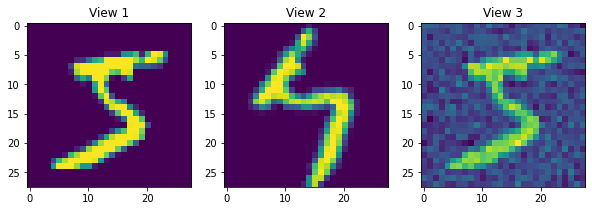

In [22]:
fig, axes = plt.subplots(1,3, figsize=(10,10))

axes[0].imshow(train_views[0][0].squeeze().numpy())
axes[0].set_title('View 1')
axes[1].imshow(train_views[1][0].squeeze().numpy())
axes[1].set_title('View 2')
axes[2].imshow(train_views[2][0].squeeze().numpy())
axes[2].set_title('View 3')

In [23]:
fig.savefig('plt/mnist_views.pdf')

In [16]:
train_views[0][0].shape

torch.Size([1, 28, 28])

In [11]:
#     train_set, train_classes = get_mnist_dataset(train=True)
#     val_set, val_classes = get_mnist_dataset(train=False)

dgcca = torch.load('trained_models/dgcca_mnist_ae1.model')
dgcca.to(device)
dgcca.eval()
        
val_views = list(val_set.to(device))
val_target = 4*[val_classes]
    
val_out = dgcca(val_views)
val_G = g_step(torch.stack(val_out).clone().detach().type(torch.float32))
val_out = [view.type(torch.float32) for view in val_out]
val_out.append(val_G)

classifier = torch.load('trained_models/dgcca_mnist_classifier.model')
classifier_fed = torch.load('trained_models/dgcca_mnist_classifier_fed.model')
# dgcca.eval()
# dgcca_fed.eval()

out_val = classifier(val_out)
classifier_acc = classifier.accuracy(out_val, val_target)

dgcca = torch.load('trained_models/dgcca_mnist_ae1_fed.model')
dgcca.to(device)
dgcca.eval()
        
val_views = list(val_set.to(device))
val_target = 4*[val_classes]
    
val_out = dgcca(val_views)
val_G = g_step(torch.stack(val_out).clone().detach().type(torch.float32))
val_out = [view.type(torch.float32) for view in val_out]
val_out.append(val_G)


out_val = classifier_fed(val_out)
classifier_fed_acc = classifier_fed.accuracy(out_val, val_target)
        


In [13]:
classifier_acc

[0.952, 0.9546, 0.9469, 0.9474]

In [14]:
classifier_fed_acc

[0.9501, 0.9527, 0.949, 0.9471]

In [10]:
dgcca_fed_acc

[0.9501, 0.9527, 0.949, 0.9471]

In [ ]:
vanilla = torch.load('trained_models/dgcca_sgd_classifier.model')
fed = torch.load('trained_models/dgcca_fed_sgd_classifier.model')

val_set, val_classes = get_mnist_dataset(train=False)
val_views = list(train_set.to(device))
    
# out1 = dgcca_vanilla(train_views)

out1 = dgcca_vanilla(val_views)
G1 = g_step(torch.stack(out1).clone().detach())
out1 = [a.type(torch.float32).detach() for a in out1]

out2 = dgcca_fed(val_views)
G2 = g_step(torch.stack(out2).clone().detach())
out2 = [a.type(torch.float32).detach() for a in out2]

vanilla_class = []
for i in range(3):
    a = vanilla.model_list[i](out1[i])
    vanilla_class.append((a.squeeze().round() - train_classes[i].to('cuda')).abs().sum())
    
a = vanilla.model_list[3](G1.type(torch.float32))
vanilla_class.append((a.squeeze().round() - train_classes[0].to('cuda')).abs().sum())


fed_class = []
for i in range(3):
    a = fed.model_list[i](out2[i])
    fed_class.append((a.squeeze().round() - train_classes[i].to('cuda')).abs().sum())
    
a = fed.model_list[3](G2.type(torch.float32))
fed_class.append((a.squeeze().round() - train_classes[0].to('cuda')).abs().sum())

In [ ]:
#     train_set, train_classes = get_mnist_dataset(train=True)
#     val_set, val_classes = get_mnist_dataset(train=False)
    
    train_views = list(train_set.to(device))
    val_views = list(train_set.to(device))
    
#     one_hot_train = torch.zeros((len(train_classes), 10))
#     one_hot_train[torch.arange(len(train_classes)), train_classes] = 1

#     one_hot_val = torch.zeros((len(val_classes), 10))
#     one_hot_val[torch.arange(len(val_classes)), val_classes] = 1

    train_target = 4*[train_classes]
    val_target = 4*[val_classes]
    
    train_out = dgcca(train_views)
    train_G = g_step(torch.stack(train_out).clone().detach().type(torch.float32))

    val_out = dgcca(val_views)
    val_G = g_step(torch.stack(val_out).clone().detach().type(torch.float32))

In [7]:
one_hot_train = torch.zeros((len(train_classes), 10))
one_hot_train[torch.arange(len(train_classes)), train_classes] = 1

one_hot_val = torch.zeros((len(val_classes), 10))
one_hot_val[torch.arange(len(val_classes)), val_classes] = 1

train_target = 4*[one_hot_train]

In [10]:
train_target[2]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [6]:
train_classes[0]

tensor(5)

In [8]:
ae_loss = (run.latent_dim/(2*28*28*target.shape[0]))*torch.norm(torch.stack(dgcca.ae(batch)) - torch.stack(batch))


In [9]:
ae_loss

tensor(0.0125, grad_fn=<MulBackward0>)

In [4]:
ae = torch.load("trained_models/dgcca_mnist_ae.model")

In [5]:
torch.save(ae, "trained_models/dgcca_mnist1.model")

In [3]:
batch[0].shape

torch.Size([1000, 1, 28, 28])

In [5]:
out = torch.stack(dgcca.ae(batch))

In [6]:
out.shape

torch.Size([3, 1000, 1, 28, 28])

In [7]:
torch.stack(batch).shape

torch.Size([3, 1000, 1, 28, 28])

In [16]:
ae_loss = run.latent_dim**2/(2*(28*28)**2) *torch.norm(torch.stack(dgcca.ae(batch)) - torch.stack(batch))


In [15]:
100/((28*28)**2)

0.0001626926280716368

In [17]:
ae_loss

tensor(0.3137, grad_fn=<MulBackward0>)

In [10]:
dgcca_loss = 1/2*torch.norm(torch.stack(dgcca(batch))-target)/target.shape[0] 


In [11]:
dgcca_loss

tensor(0.0237, grad_fn=<DivBackward0>)

In [ ]:
dgcca_loss = 

In [2]:
import numpy as np
from sklearn.manifold import TSNE

X = G[:10000].numpy()
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(10000, 2)

Text(0.5, 1.0, 't-SNE plot of latent representation G')

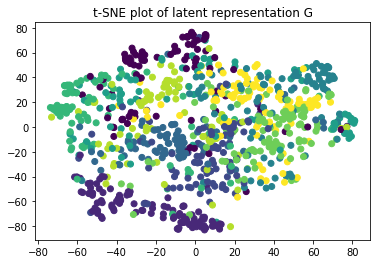

In [3]:
fig, axes = plt.subplots(1,1)

axes.scatter(X_embedded[:1000,0], X_embedded[:1000,1], c=train_classes[:1000].numpy())
axes.set_title('t-SNE plot of latent representation G')

Text(0.5, 1.0, 't-SNE plot of latent representation G')

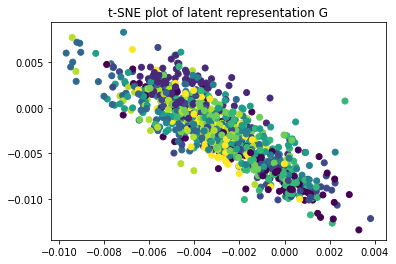

In [32]:
fig, axes = plt.subplots(1,1)

axes.scatter(G[:1000,0], G[:1000,1], c=train_classes[:1000].numpy())
axes.set_title('t-SNE plot of latent representation G')

In [19]:
fig.savefig('plt/tsne_cifar.pdf')

In [15]:
classes

tensor([6, 7, 9,  ..., 1, 1, 5])

In [1]:
import torch
from models import MnistAutoencoder

ae = MnistAutoencoder()

z = ae(torch.randn((1,1,28,28)))

torch.Size([1, 16, 14, 14])
torch.Size([1, 16, 14, 14])
torch.Size([1, 32, 7, 7])
torch.Size([1, 32, 7, 7])
torch.Size([1, 32, 7, 7])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 2, 2])
torch.Size([1, 64, 2, 2])
torch.Size([1, 64, 2, 2])
torch.Size([1, 256])
torch.Size([1, 10])


In [31]:
G.shape

torch.Size([60000, 2])